# GAN on MNIST - scratch 
### O. Osoba
### Date: 1-Nov-2017
Exploring Generative Adversarial Networks (GAN) on MNIST.
Adapting from A. Damien's GAN example at:
    https://github.com/aymericdamien/TensorFlow-Examples/
Using generative adversarial networks (GAN) to generate plans from a
noise distribution.
References:
Generative adversarial nets. I Goodfellow et al. NIPS, 2672-2680.
Understanding the difficulty of training deep feedforward neural networks. X Glorot, Y Bengio. Aistats 9, 249-256
Links:
[GAN Paper](https://arxiv.org/pdf/1406.2661.pdf).
[MNIST Dataset](http://yann.lecun.com/exdb/mnist/).
[Xavier Glorot Init](www.cs.cmu.edu/~bhiksha/courses/deeplearning/Fall.../AISTATS2010_Glorot.pdf).

In [ ]:
from __future__ import division, print_function, absolute_import
import argparse, sys, os, re, json, csv

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

import collections, itertools
from more_itertools import unique_everseen

%pylab inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7,7)

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST/", one_hot=True)

Extracting ./MNIST/train-images-idx3-ubyte.gz
Extracting ./MNIST/train-labels-idx1-ubyte.gz
Extracting ./MNIST/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
# Training Params
num_steps = 100000
batch_size = 128
learning_rate = 0.0002

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # Noise data points

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [4]:
# Store layers weight & bias
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}

In [5]:
# Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

In [6]:
# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)  # G(z)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input) # D(x)
disc_fake = discriminator(gen_sample) # DoG(z)

# GANs objective fxn: 
# min_G max_D E_x[log(D(x))] + E_z[log(1-D(G(z)))]
# z~Noise, x~Data
# obj spec'd as maximizations (-ve sign) of E[logDoG(z)] and E[logD(x)] (see Goodfellow ref...)
# Implementation of GAN minimax objective/loss fxn
gen_loss = -tf.reduce_mean(tf.log(disc_fake)) # -E_z[log(DoG(z))]
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake)) # -(E[log(D(x)) + log(DoG(z))])


# Training Variables for each optimizer
# By default TF optimizers update all variables
# GANs training requires precise switching between vars to update
# the following specs which variables to update:
# On Generator Network Variables update cycles
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
# On Discriminator Network Variables update cycles
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]


# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)
# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [7]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)
gls = []
dls = []

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
    gls.append(gl)
    dls.append(dl)
    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 0.627058, Discriminator Loss: 1.505434
Step 2000: Generator Loss: 4.373276, Discriminator Loss: 0.048192
Step 4000: Generator Loss: 4.266341, Discriminator Loss: 0.053190
Step 6000: Generator Loss: 3.841968, Discriminator Loss: 0.069987
Step 8000: Generator Loss: 4.470514, Discriminator Loss: 0.053223
Step 10000: Generator Loss: 3.966380, Discriminator Loss: 0.122163
Step 12000: Generator Loss: 3.699428, Discriminator Loss: 0.236582
Step 14000: Generator Loss: 3.703249, Discriminator Loss: 0.269915
Step 16000: Generator Loss: 3.107471, Discriminator Loss: 0.476518
Step 18000: Generator Loss: 3.906837, Discriminator Loss: 0.270426
Step 20000: Generator Loss: 3.687313, Discriminator Loss: 0.306399
Step 22000: Generator Loss: 3.547396, Discriminator Loss: 0.281011
Step 24000: Generator Loss: 4.127071, Discriminator Loss: 0.224202
Step 26000: Generator Loss: 3.651759, Discriminator Loss: 0.289547
Step 28000: Generator Loss: 3.475249, Discriminator Loss: 0.386142
Ste

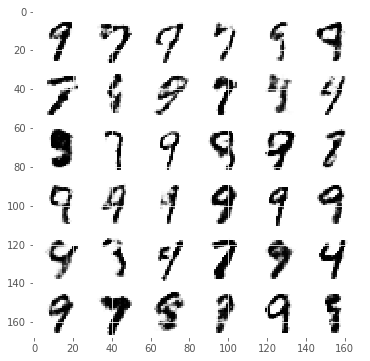

In [8]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={gen_input: z})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

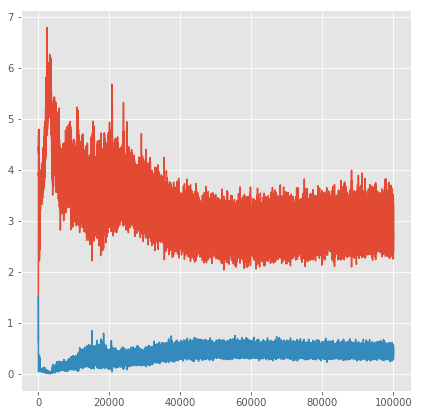

In [9]:
plt.plot(gls) 
plt.plot(dls)